# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
Описание данных games.csv

    Name — название игры
    Platform — платформа
    Year_of_Release — год выпуска
    Genre — жанр игры
    NA_sales — продажи в Северной Америке (миллионы долларов)
    EU_sales — продажи в Европе (миллионы долларов)
    JP_sales — продажи в Японии (миллионы долларов)
    Other_sales — продажи в других странах (миллионы долларов)
    Critic_Score — оценка критиков (от 0 до 100)
    User_Score — оценка пользователей (от 0 до 10)
    Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

### 1. Скачаем датасет, посмотрим первые 5 строк

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st

import matplotlib.pyplot as plt
%matplotlib inline

import pprint
from IPython.display import display

In [2]:
df = pd.read_csv('/datasets/games.csv')

df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### 2. Общая информация

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
df.shape

(16715, 11)

In [5]:
df.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year_of_Release,16446.0,2006.484616,5.877050,1980.0,2003.0,2007.00,2010.00,2016.00
NA_sales,16715.0,0.263377,0.813604,0.0,0.0,0.08,0.24,41.36
EU_sales,16715.0,0.145060,0.503339,0.0,0.0,0.02,0.11,28.96
JP_sales,16715.0,0.077617,0.308853,0.0,0.0,0.00,0.04,10.22
Other_sales,16715.0,0.047342,0.186731,0.0,0.0,0.01,0.03,10.57
Critic_Score,8137.0,68.967679,13.938165,13.0,60.0,71.00,79.00,98.00


В датасете 16715 объектов.

Признаки Year_of_Release, NA_sales, EU_sales, JP_sales, Other_sales, Critic_Score имеют тип данных float64 (что для года выпуска не вполне обычно).

Признак User_Score имеет тип данных object, надо отлить во float.

Призники Name, Platform, Genre, Rating имеют тип данных object и являются категориальными.

Пропуски данных в рейтингах от половины до трети данных, в годе выпуска 1.5% данных, в названии игры у двух объектов.

### 3. подготовка данных

In [7]:
# приведем названия признаков к нижнему регистру

df.columns = [c.lower() for c in df.columns]
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [8]:
df[df['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пропуски в имени игры и жанре у объектов выпуска 1993 года с незначительными продажами и отсутствующими рейтингами. Их удаление не повлияет на результат исследования.

In [9]:
df.dropna(subset=['name'], inplace=True)
df[df['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Признак user_score отлить во float невозможно из-за некого "tbd" в значениях. Таких объектов 2424. Что значит "tbd" мне неведомо, может быть, to be discussed, в любом случае, будет разумно заменить его на np.nan 

In [10]:
df.query('user_score in ["tbd"]').describe().T

,count,mean,std,min,25%,50%,75%,max
year_of_release,2376.0,2007.450337,3.484229,1997.0,2005.00,2008.000,2010.00,2016.00
na_sales,2424.0,0.126052,0.180586,0.0,0.03,0.075,0.15,3.45
eu_sales,2424.0,0.043519,0.111412,0.0,0.00,0.010,0.04,2.59
jp_sales,2424.0,0.002727,0.026136,0.0,0.00,0.000,0.00,0.86
other_sales,2424.0,0.015862,0.039156,0.0,0.00,0.010,0.02,1.09
critic_score,1082.0,60.711645,11.193035,23.0,54.00,62.000,69.00,90.00


In [11]:
df['user_score'].replace('tbd', np.nan, inplace=True)
df.query('user_score in ["tbd"]').shape[0]

0

In [12]:
# теперь user_score будет преобразован во float

df['user_score'] = df['user_score'].astype('float')

Преобразуем critic_score к единой шкале с user_score, разделив на 10 и посмотрим распределение значений

In [13]:
df['critic_score'] /= 10

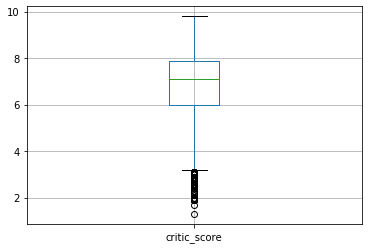

In [14]:
df.boxplot(['critic_score']);

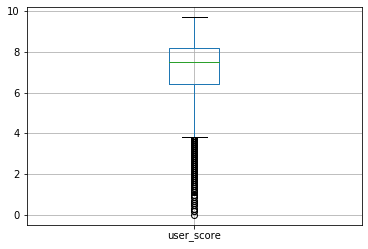

In [15]:
df.boxplot('user_score');

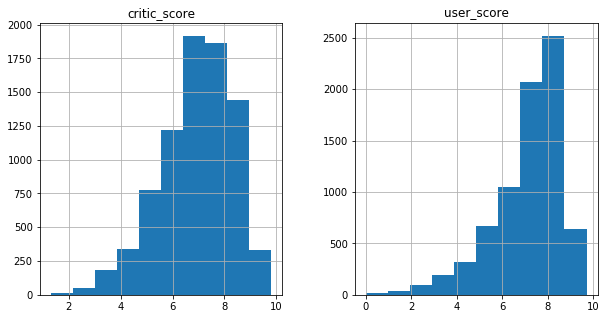

In [16]:
df[['critic_score', 'user_score']].hist(figsize=(10, 5));

Распределение значений почти нормальное, за исключением выбросов близких к нулю значений. Если игнорировать оценки меньше 5, распределение будет нормальным.

In [17]:
# df['critic_score'].fillna(df['critic_score'].mean(), inplace=True)
# df['user_score'].fillna(df['user_score'].mean(), inplace=True)

Попробуем определить причину пропусков в рейтингах

In [18]:
df[df['user_score'].isnull()]['critic_score'].isnull().sum()

8003

In [19]:
df[df['user_score'].isnull()]['rating'].isnull().sum()

6678

In [20]:
df[df['user_score'].isnull()]['year_of_release'].isnull().sum()

142

In [21]:
df[df['year_of_release'].isnull()].groupby('platform')['name'].count()

platform
2600    17
3DS      8
DS      30
GB       1
GBA     11
GC      14
N64      3
PC      17
PS       7
PS2     34
PS3     25
PSP     16
PSV      1
Wii     34
X360    30
XB      21
Name: name, dtype: int64

In [22]:
set(df.platform) - set(df[df['year_of_release'].isnull()]['platform'])

{'3DO',
 'DC',
 'GEN',
 'GG',
 'NES',
 'NG',
 'PCFX',
 'PS4',
 'SAT',
 'SCD',
 'SNES',
 'TG16',
 'WS',
 'WiiU',
 'XOne'}

Почти все пропуски (более 90%) в rating и critic_score находятся в выборке df[df['user_score'].isnull()]. Видимо, датасет объединен из нескольких таблиц, некоторые из которых была не до конца обработаны: в них не были подгружены рейтинги.

Почему пропуски в year_of_release непонятно, чуть больше половина пропусков в year_of_release в выборке df[df['user_score'].isnull()]. Около половины платформ не имеют пропусков в year_of_release. Возможно, при подгрузке таблиц с данными по платформам произошли те или иные ошибки.

Пропуски в рейтингах обрабатывать не будем, пропуски в годе выпуска заменим на самый распространенный год выпуска по платформе.

In [23]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [24]:
df.groupby('rating')['name'].count()

rating
AO         1
E       3990
E10+    1420
EC         8
K-A        3
M       1563
RP         3
T       2961
Name: name, dtype: int64

Есть очень редкие категории рейтинга. Посмотрим на них

In [25]:
df[df['rating'].isin(['AO', 'EC', 'K-A', 'RP'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
656,Theme Hospital,PC,1997.0,Strategy,2.30,0.10,0.00,0.00,NaN,9.0,K-A
875,Grand Theft Auto: San Andreas,XB,2005.0,Action,1.26,0.61,0.00,0.09,9.3,8.6,AO
903,PaRappa The Rapper,PS,1996.0,Misc,0.26,0.16,1.46,0.03,9.2,7.4,K-A
4297,Nickelodeon Team Umizoomi,DS,2011.0,Action,0.42,0.00,0.00,0.03,NaN,NaN,EC
5034,Sesame Street: Elmo's A-to-Zoo Adventure,Wii,2010.0,Misc,0.35,0.00,0.00,0.02,NaN,NaN,EC
6046,Sesame Street: Cookie's Counting Carnival,Wii,2010.0,Misc,0.27,0.00,0.00,0.02,NaN,NaN,EC
6764,Dora the Explorer: Journey to the Purple Planet,PS2,2005.0,Adventure,0.12,0.09,0.00,0.03,NaN,7.0,EC
7586,"Ni Hao, Kai-lan: New Year's Celebration",DS,2009.0,Misc,0.19,0.00,0.00,0.01,NaN,NaN,EC
9960,Dora the Explorer: Journey to the Purple Planet,GC,2005.0,Adventure,0.09,0.02,0.00,0.00,NaN,NaN,EC
13065,Sesame Street: Cookie's Counting Carnival,PC,2010.0,Misc,0.05,0.00,0.00,0.00,NaN,NaN,EC


In [26]:
# df['rating'].fillna('E', inplace=True)

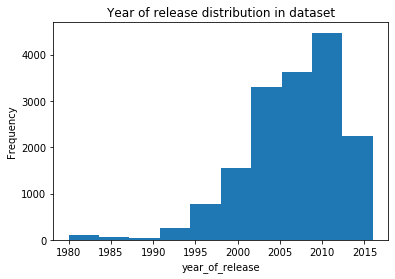

In [27]:
ax = df['year_of_release'].plot(kind='hist', title='Year of release distribution in dataset')
ax.set_xlabel("year_of_release");

In [28]:
df[df['year_of_release'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,9.4,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,8.4,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,7.4,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,4.3,NaN,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,6.9,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,5.9,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [29]:
yor_by_platform = df.groupby('platform')['year_of_release'].agg(lambda x: x.value_counts().index[0])
yor_by_platform

platform
2600    1981.0
3DO     1995.0
3DS     2011.0
DC      2000.0
DS      2008.0
GB      2000.0
GBA     2002.0
GC      2002.0
GEN     1994.0
GG      1992.0
N64     1999.0
NES     1986.0
NG      1995.0
PC      2011.0
PCFX    1996.0
PS      1998.0
PS2     2002.0
PS3     2011.0
PS4     2016.0
PSP     2006.0
PSV     2015.0
SAT     1995.0
SCD     1994.0
SNES    1995.0
TG16    1995.0
WS      2001.0
Wii     2009.0
WiiU    2013.0
X360    2011.0
XB      2003.0
XOne    2016.0
Name: year_of_release, dtype: float64

In [30]:
yor_by_platform_dict = yor_by_platform.to_dict()
df['yor_by_platform'] = df['platform'].map(yor_by_platform_dict)

In [31]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,yor_by_platform
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,7.6,8.0,E,2009.0
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,1986.0
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,8.2,8.3,E,2009.0
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,8.0,8.0,E,2009.0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,2000.0


In [32]:
i = df[df['year_of_release'].isna()].index
df.loc[i, 'year_of_release']

183     NaN
377     NaN
456     NaN
475     NaN
609     NaN
         ..
16373   NaN
16405   NaN
16448   NaN
16458   NaN
16522   NaN
Name: year_of_release, Length: 269, dtype: float64

In [33]:
df['year_of_release'] = df['year_of_release'].fillna(df['platform'].map(yor_by_platform_dict))
df.loc[i, 'year_of_release']

183      2002.0
377      2002.0
456      2009.0
475      2002.0
609      1981.0
          ...  
16373    2006.0
16405    2002.0
16448    2011.0
16458    2011.0
16522    2002.0
Name: year_of_release, Length: 269, dtype: float64

Создадим колонку общих продаж total_sales

In [37]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
df['total_sales'].values.tolist()[:20]

[82.53999999999999,
 40.24,
 35.519999999999996,
 32.77,
 31.380000000000003,
 30.259999999999998,
 29.8,
 28.91,
 28.32,
 28.31,
 24.67,
 23.209999999999997,
 23.09,
 22.7,
 21.82,
 21.8,
 21.05,
 20.810000000000002,
 20.62,
 20.14]

Наш датасет оказался отсортированным по признаку total_sales.

In [38]:
# проверим пропуски

df.isnull().sum().sum()

24463

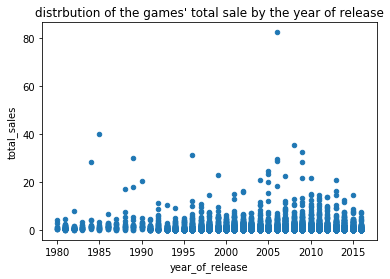

In [39]:
df.plot.scatter(x='year_of_release', y='total_sales',
                title="distrbution of the games' total sale by the year of release");

In [40]:
df.corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,yor_by_platform,total_sales
year_of_release,1.000000,-0.093136,0.004621,-0.165437,0.037993,0.011478,-0.265606,0.898970,-0.075858
na_sales,-0.093136,1.000000,0.765341,0.449668,0.638695,0.240755,0.086200,-0.047858,0.941021
eu_sales,0.004621,0.765341,1.000000,0.435079,0.722796,0.220752,0.055337,0.045747,0.901239
jp_sales,-0.165437,0.449668,0.435079,1.000000,0.291090,0.152593,0.125598,-0.148258,0.612334
other_sales,0.037993,0.638695,0.722796,0.291090,1.000000,0.198554,0.057119,0.050581,0.749280
critic_score,0.011478,0.240755,0.220752,0.152593,0.198554,1.000000,0.580878,0.044206,0.245507
user_score,-0.265606,0.086200,0.055337,0.125598,0.057119,0.580878,1.000000,-0.238168,0.088179
yor_by_platform,0.898970,-0.047858,0.045747,-0.148258,0.050581,0.044206,-0.238168,1.000000,-0.033751
total_sales,-0.075858,0.941021,0.901239,0.612334,0.749280,0.245507,0.088179,-0.033751,1.000000


### 4. Исследовательский анализ данных.

In [41]:
# сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

df.groupby('year_of_release')['name'].count().reset_index().sort_values('year_of_release', ascending=False)

,year_of_release,name
36,2016.0,502
35,2015.0,607
34,2014.0,581
33,2013.0,544
32,2012.0,653
31,2011.0,1216
30,2010.0,1255
29,2009.0,1460
28,2008.0,1457
27,2007.0,1197


В датасете нет разбиения продаж каждой игры по годам с момента выпуска, что могло бы дать информацию о росте или снижении популярности игры во времени. Но, исходя из имеющихся данных, можно сделать предположение, что игры с годом выпуска ранее 1994 нет смысла учитывать вовсе, а игры игры с годом выпуска ранее 2002 малозначительны для нашего анализа.

In [42]:
# как менялись продажи по платформам

top15_sales_by_platform = df.groupby('platform')['total_sales'].\
                            sum().reset_index().sort_values('total_sales', ascending=False).head(15)
top15_sales_by_platform

,platform,total_sales
16,PS2,1255.77
28,X360,971.42
17,PS3,939.65
26,Wii,907.51
4,DS,806.12
15,PS,730.86
6,GBA,317.85
18,PS4,314.14
19,PSP,294.05
13,PC,259.52


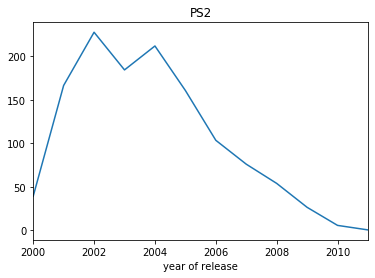

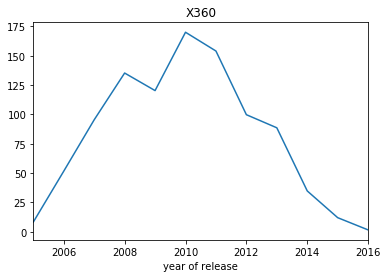

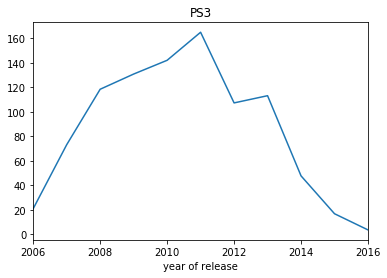

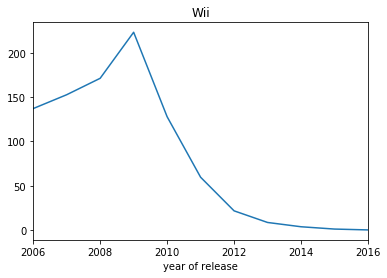

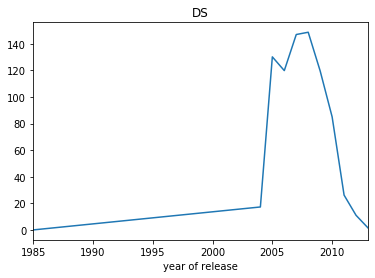

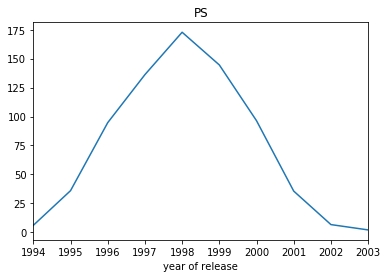

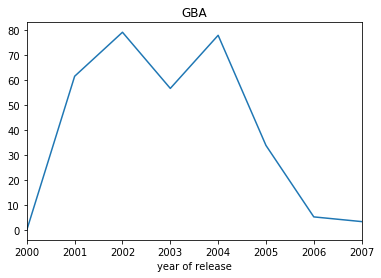

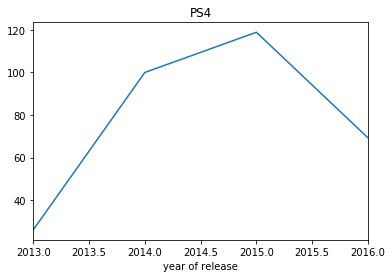

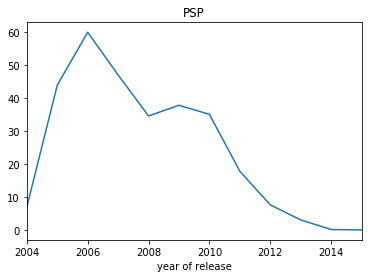

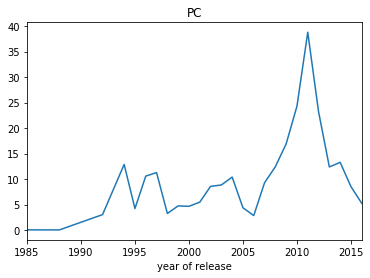

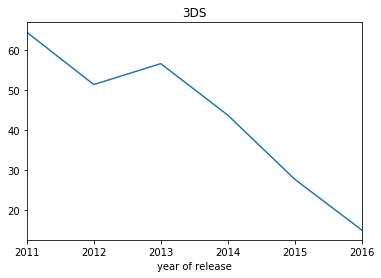

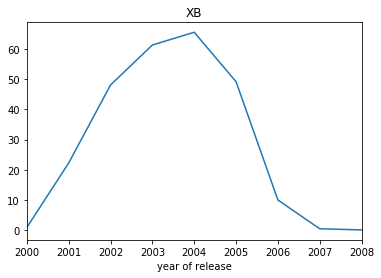

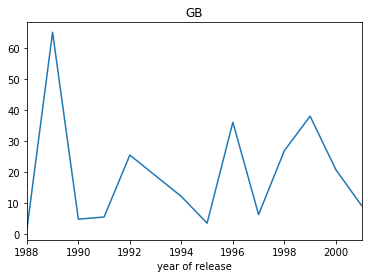

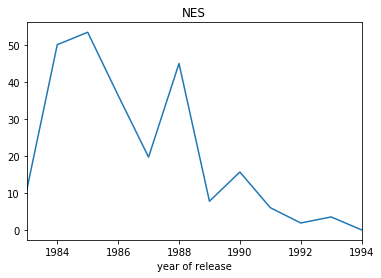

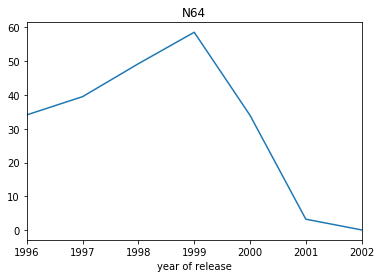

In [43]:
# Выберем платформы с наибольшими суммарными продажами и постройте распределение по годам

top15 = top15_sales_by_platform['platform'].tolist()
for p in top15:
    plt.figure()
    df[df['platform'] == p].groupby('year_of_release')['total_sales'].sum().plot(title=p)
    plt.xlabel('year of release')
    plt.show()

In [44]:
platform_life = df.query('platform == @top15').\
                    pivot_table(values='year_of_release',
                                index='platform',
                                aggfunc=('min', 'max'))
platform_life

,max,min
platform,,
3DS,2016.0,2011.0
DS,2013.0,1985.0
GB,2001.0,1988.0
GBA,2007.0,2000.0
N64,2002.0,1996.0
NES,1994.0,1983.0
PC,2016.0,1985.0
PS,2003.0,1994.0
PS2,2011.0,2000.0


In [45]:
platform_life['lifetime'] = platform_life['max'] - platform_life['min']
platform_life

,max,min,lifetime
platform,,,
3DS,2016.0,2011.0,5.0
DS,2013.0,1985.0,28.0
GB,2001.0,1988.0,13.0
GBA,2007.0,2000.0,7.0
N64,2002.0,1996.0,6.0
NES,1994.0,1983.0,11.0
PC,2016.0,1985.0,31.0
PS,2003.0,1994.0,9.0
PS2,2011.0,2000.0,11.0


In [46]:
# чтобы исключить выбросы берем медиану

print('В среднем платформа живет', platform_life['lifetime'].median(), 'лет')

В среднем платформа живет 10.0 лет


На основании анализа топ-15 платформ понятно, что платформы "живут" порядка 10 лет.

Поскольку первую половину этого срока идет подъем, а вторую спад, то есть смысл рассматривать игры не позже 5 лет с момента выпуска (на шестой год ожидается спад, но он может быть пока не критичным).

In [47]:
df_upd = df.query('year_of_release > 2011')
df_upd.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,yor_by_platform,total_sales
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,9.7,8.2,M,2011.0,21.05
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,9.7,8.1,M,2011.0,16.27
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,2016.0,14.63
33,Pokemon X/Pokemon Y,3DS,2013.0,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,2011.0,14.60
34,Call of Duty: Black Ops II,PS3,2012.0,Shooter,4.99,5.73,0.65,2.42,8.3,5.3,M,2011.0,13.79


In [48]:
print('В датасете останется', df_upd.shape[0], 'объектов')

В датасете останется 2887 объектов


In [49]:
sales_by_platform = df_upd.groupby('platform')['total_sales'].\
                            sum().reset_index().sort_values('total_sales', ascending=False)
sales_by_platform

,platform,total_sales
4,PS4,314.14
3,PS3,288.79
9,X360,236.54
0,3DS,194.61
10,XOne,159.32
8,WiiU,82.19
2,PC,62.65
6,PSV,49.44
7,Wii,35.37
1,DS,12.55


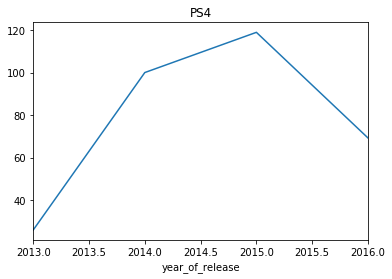

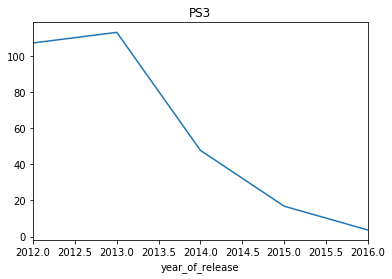

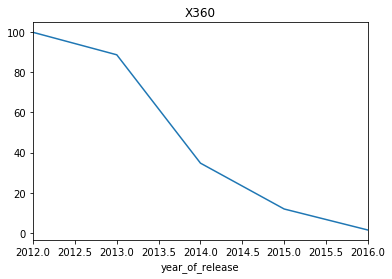

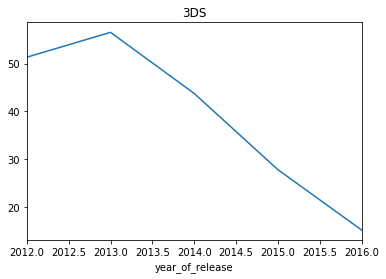

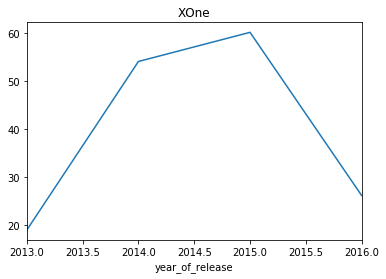

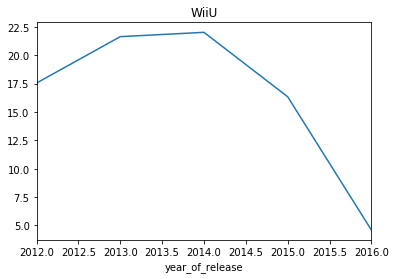

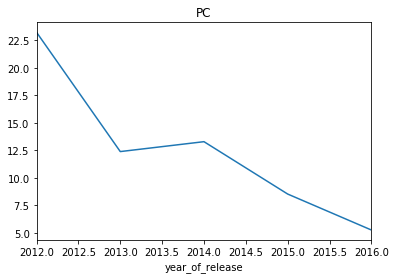

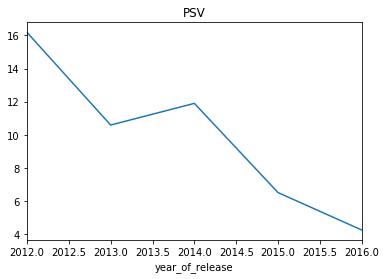

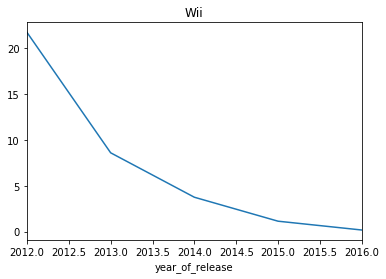

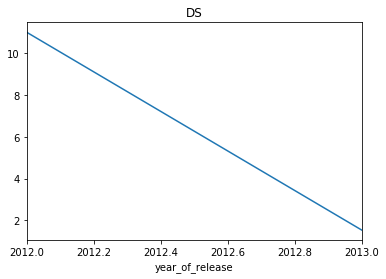

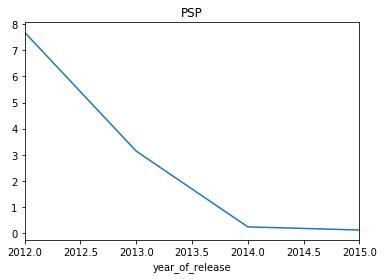

In [50]:
for p in sales_by_platform['platform']:
    plt.figure()
    df_upd[df_upd['platform'] == p].groupby('year_of_release')['total_sales'].sum().plot(title=p)
    plt.show()

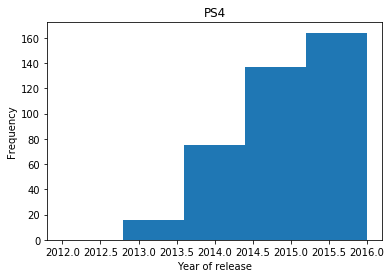

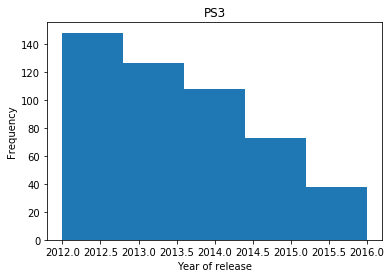

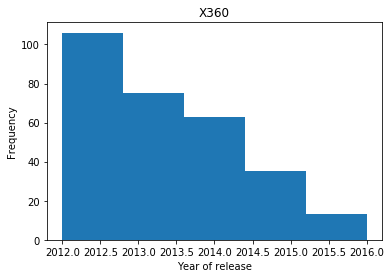

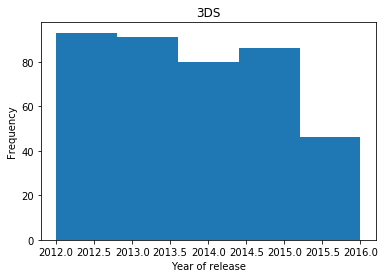

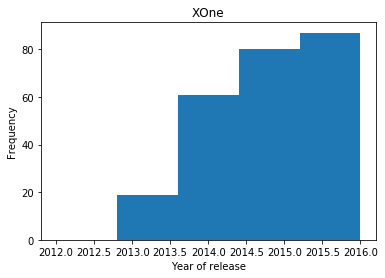

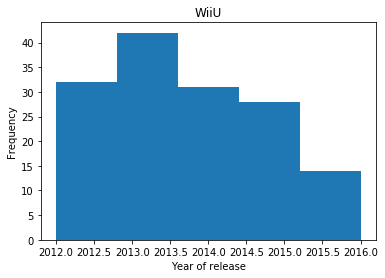

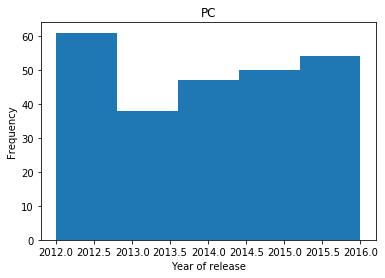

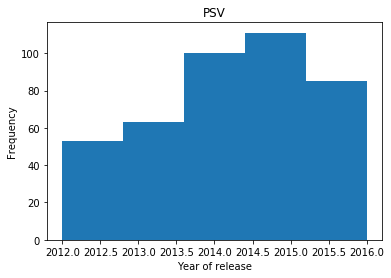

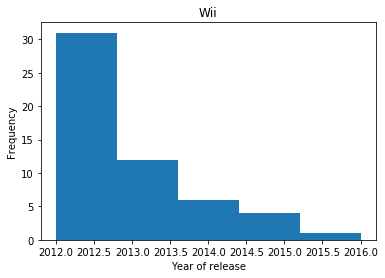

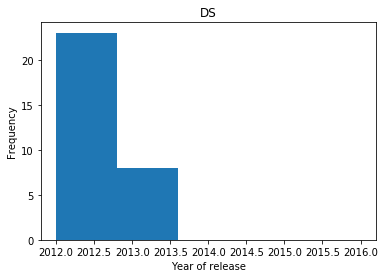

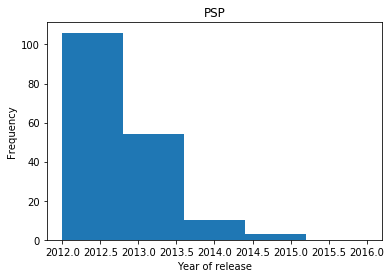

In [51]:
top_plats = sales_by_platform['platform']

for p in sales_by_platform['platform']:
    plt.figure()
    df_upd[df_upd['platform'] == p]['year_of_release'].plot(kind='hist',
                                                            bins=5, 
                                                            range=(2012, 2016),
                                                            title=p)
    plt.xlabel('Year of release')
    plt.show()

Судя по полученным распределениям, наилучшие перспективы для доходности продаж имеют игры платформ PS4, XOne, PC и, возможно, PS3, WiiU, 3DS, PCV.

In [52]:
# график "ящик с усами" по глобальным продажам каждой игры и разбивкой по платформам

sales_by_platform = df_upd.pivot_table(values='total_sales',
                                       index='year_of_release',
                                       columns='platform',
                                       fill_value=0,
                                       aggfunc='sum')
sales_by_platform

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012.0,51.36,11.01,23.22,107.36,0.00,7.69,16.19,21.71,17.56,99.74,0.00
2013.0,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014.0,43.76,0.00,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015.0,27.78,0.00,8.52,16.82,118.90,0.12,6.51,1.14,16.35,11.96,60.14
2016.0,15.14,0.00,5.25,3.60,69.25,0.00,4.25,0.18,4.60,1.52,26.15


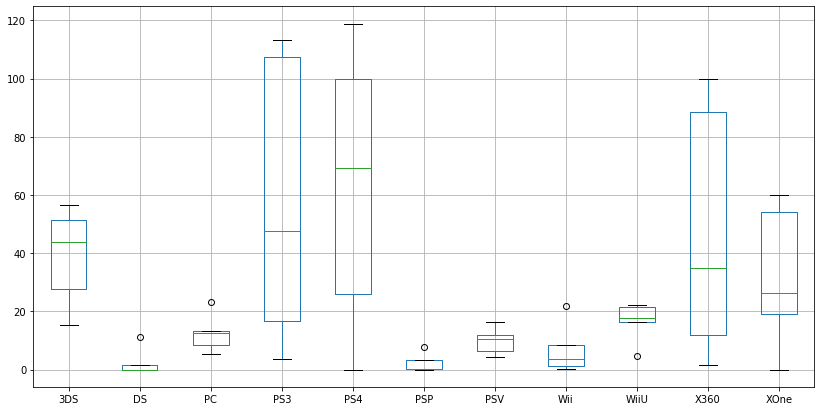

In [53]:
sales_by_platform.boxplot(figsize=(14, 7));

Продажи игр по платформам отличаются кратно, средние продажи распределены более равномерно.

Видимо, игры платформ с небольшим разбросом в продажах и невысокими их )продаж средними показателями) не имеют большой маркетинговой составляющей и недороги в производстве. Именно у них встречаются выбросы - это, скорее всего, какие-то остро популярные игры, продающиеся с существенной наценкой за популярность.

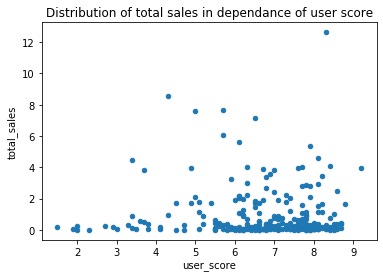

In [54]:
# влияние на продажи внутри PS4 отзывов пользователей и критиков

sales_from_score = df_upd[df_upd['platform'] == 'PS4'][['total_sales', 'user_score', 'critic_score']]
sales_from_score.plot.scatter(x='user_score', y='total_sales',
                              title='Distribution of total sales in dependance of user score');

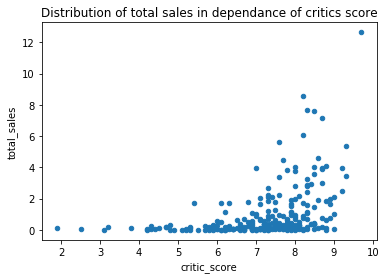

In [55]:
sales_from_score.plot.scatter(x='critic_score', y='total_sales',
                              title='Distribution of total sales in dependance of critics score');

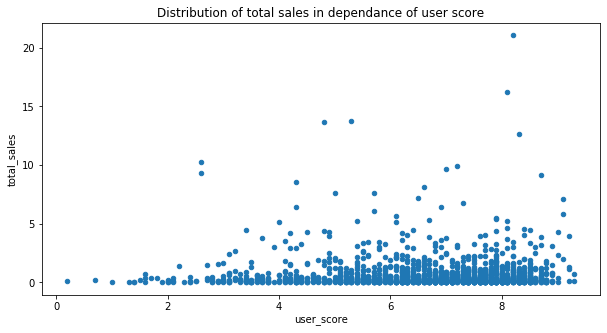

In [56]:
# для PS4 получилась наглядная картина, проверим её на датасете
# из наиболее актуальных платформ

sales_from_score = df_upd[df_upd['platform'].isin(top_plats)][['total_sales',
                                                               'user_score',
                                                               'critic_score']]
sales_from_score.plot.scatter(x='user_score', y='total_sales', figsize=(10, 5),
                              title='Distribution of total sales in dependance of user score');

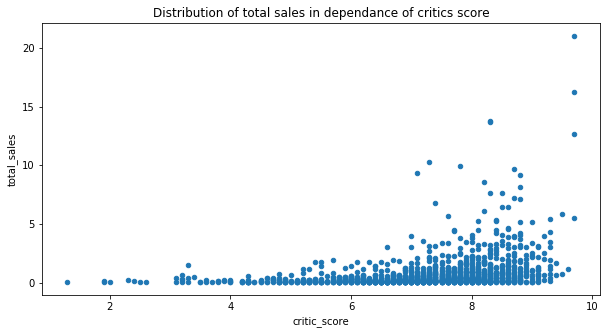

In [57]:
sales_from_score.plot.scatter(x='critic_score', y='total_sales', figsize=(10, 5),
                              title='Distribution of total sales in dependance of critics score');

Можно сказать, что выручка от продаж не зависит от оценок, данных игре пользователями и критиками. Впрочем, если для пользовательского рейтинга это замечание полностью верно, то для рейтинга критиков - отчасти: при рейтинге критиков < 7 шансов на успешные продажи у игры нет совсем, от 7 и выше они есть (хотя и вовсе не гарантированы). При введении соответствующего бинарного признака для рейтинга критиков, можно сразу отсеивать из рассмотрения игры с рейтингом < 7. По-видимому, это связано с большей компетентностью критиков.

Справедливости ради, можно предположить, что введение похожего бинарного признака для пользовательского рейтинга <=2 тоже будет полезным.

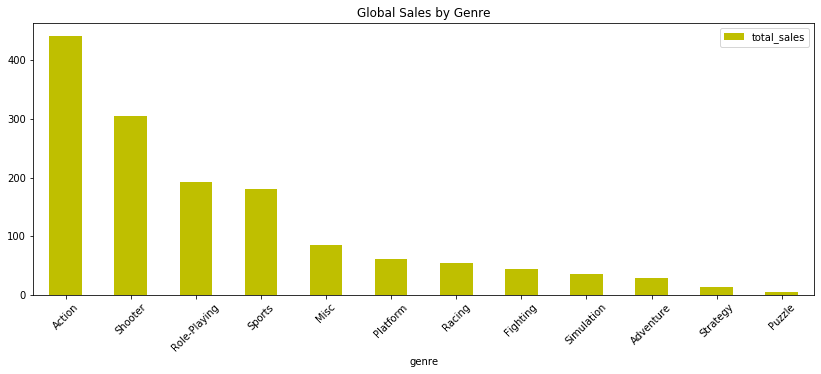

In [58]:
# общее распределение игр по жанрам

sales_by_genre = df_upd.groupby('genre')['total_sales'].sum().\
                    reset_index().sort_values('total_sales',
                                              ascending=False)
sales_by_genre.plot(x='genre', y='total_sales',
                    kind='bar', color='y', figsize=(14, 5),
                    title='Global Sales by Genre', rot=45);

Распределение продаж по жанрам, разумеется, совершенно очевидно. Есть наиболее прибыльные жанры, это Action, Shooter, Sports, Role-Playing и все остальные.

### 5. портрет пользователя каждого региона (NA, EU, JP)

In [59]:
# топ-5 платформы по регионам

# Для начала получим сводную таблицу для продаж по платформам и по регионам,
# отсортированную по eu_sales
df_upd.pivot_table(values=['na_sales', 'eu_sales', 'jp_sales'],
                   index='platform', aggfunc='sum').\
                                reset_index().\
                                sort_values('eu_sales',
                                            ascending=False).set_index('platform')

,eu_sales,jp_sales,na_sales
platform,,,
PS4,141.09,15.96,108.74
PS3,106.86,35.29,103.38
X360,74.52,1.57,140.05
XOne,51.59,0.34,93.12
3DS,42.64,87.79,55.31
PC,37.76,0.00,19.12
WiiU,25.13,13.01,38.10
Wii,11.92,3.39,17.45
PSV,11.41,21.11,11.09


In [60]:
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    res = df_upd.pivot_table(values=region,
                             index='platform',
                             aggfunc='sum')
    res = res.reset_index().sort_values(region, ascending=False).head()
    print(region)
    display(res.set_index('platform'))
    print()

na_sales


,na_sales
platform,
X360,140.05
PS4,108.74
PS3,103.38
XOne,93.12
3DS,55.31



eu_sales


,eu_sales
platform,
PS4,141.09
PS3,106.86
X360,74.52
XOne,51.59
3DS,42.64



jp_sales


,jp_sales
platform,
3DS,87.79
PS3,35.29
PSV,21.11
PS4,15.96
WiiU,13.01


В регионах NA и EU вкусы схожи: топ-5 продаж игр по платформам по составу совпадают, и лидер один - PS4. В регионе JP лидирует платформа 3DS, занимающая последнее место в NA и EU, кроме того, в топ-5 JP вошли две платформы, отсутствующие в топ-5 NA и EU (это PSV и WiiU), а лидер продаж NA и EU в JP на предпоследнем месте, при том, что его, видимо, предыдущая версия в JP - на втором.

Отличие японского рынка заметны и состоят из двух компонент.
1. Патриотизм. Платформы японских производителей имеют приоритет. 
2. Можно предположить некоторое отставание по темпам набора популярности игр обновленных платформ по сравнению с Европой и США.

In [61]:
# Влияение рейтинга ESRB на продажи в отдельном регионе

ESRB_rate = df_upd.pivot_table(values=['na_sales',
                                       'eu_sales',
                                       'jp_sales'],
                               index='rating', aggfunc='sum').\
                                        reset_index().\
                                        sort_values('eu_sales',
                                                    ascending=False)
ESRB_rate = ESRB_rate.set_index('rating')
ESRB_rate

,eu_sales,jp_sales,na_sales
rating,,,
M,193.96,21.20,231.57
E,113.03,28.33,114.37
E10+,55.37,8.19,75.70
T,53.01,26.09,66.13


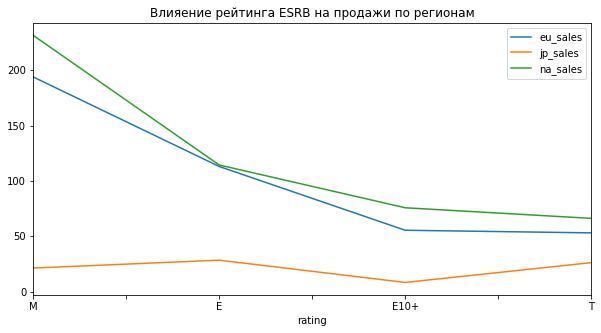

In [62]:
ESRB_rate.plot(figsize=(10, 5), title='Влияение рейтинга ESRB на продажи по регионам');

Разницы в продажах по регионам нет. Продажи во всем мире двигают взрослые игры. То есть, взрослые активно играют в игры. Если взять долю подростков в популяции, то доля игр для подростков, скорее всего, вполне адекватна и даже превышает равновесную со взрослыми. Замечено, что доля продажи Японии в продажах игр с рейтингом Т явно выше средней, а с рейтингом М явно меньше средней. А в Европе выше средней по миру доля игр с индексом Е.

### 6. Проведем исследование статистических показателей

In [63]:
# изменение пользовательского рейтинга и рейтинга критиков в различных жанрах

stats = df_upd.pivot_table(values=['critic_score', 'user_score'],
                           index='genre', aggfunc=['mean', 'std', 'var'])
stats

mean                     std                     var  \
             critic_score user_score critic_score user_score critic_score   
genre                                                                       
Action           7.137844   6.825048     1.209375   1.374440     1.462588   
Adventure        7.266102   7.466667     1.100096   1.277652     1.210210   
Fighting         7.040625   6.895714     1.340779   1.431269     1.797688   
Misc             7.280702   6.938806     1.005421   1.257939     1.010871   
Platform         7.461017   6.806061     1.371385   1.654447     1.880695   
Puzzle           7.544444   7.633333     0.694822   0.888819     0.482778   
Racing           7.186420   6.151163     1.254368   1.667597     1.573438   
Role-Playing     7.308025   7.260465     1.225048   1.275159     1.500743   
Shooter          7.342197   6.435897     1.244527   1.437188     1.548849   
Simulation       6.661538   6.511905     1.355615   1.812585     1.837692   
Sports           7.289510   5.455897     1.547315   1.738646     2.394185   
Strategy         7.587097   6.420000     1.251597   2.030908     1.566495   

                         
             user_score  
genre                    
Action         1.889084  
Adventure      1.632394  
Fighting       2.048532  
Misc           1.582411  
Platform       2.737193  
Puzzle         0.790000  
Racing         2.780881  
Role-Playing   1.626030  
Shooter        2.065509  
Simulation     3.285465  
Sports         3.022890  
Strategy       4.124588

In [64]:
df_upd.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'yor_by_platform', 'total_sales'],
      dtype='object')

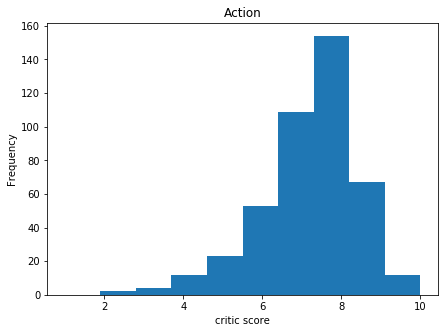

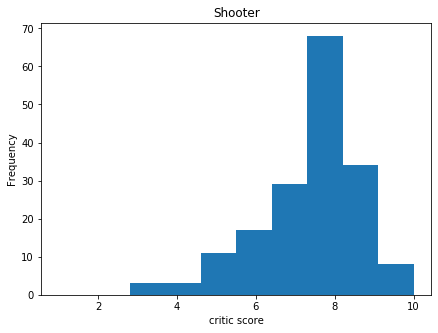

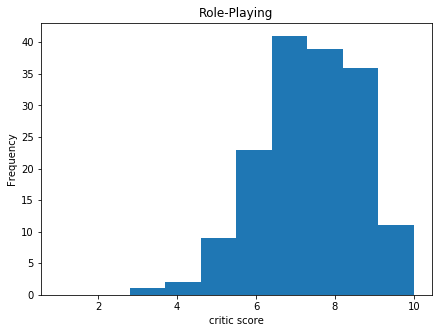

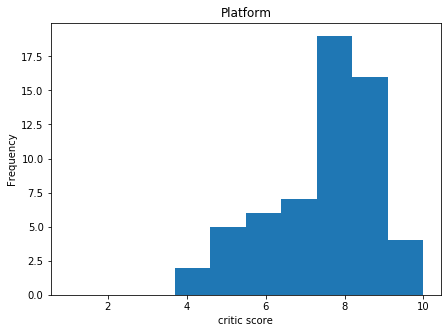

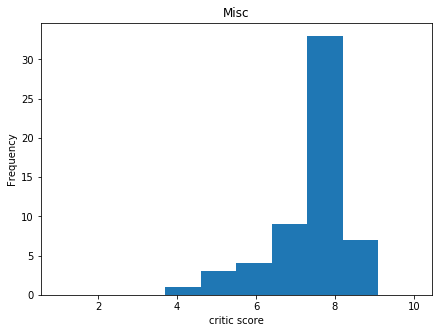

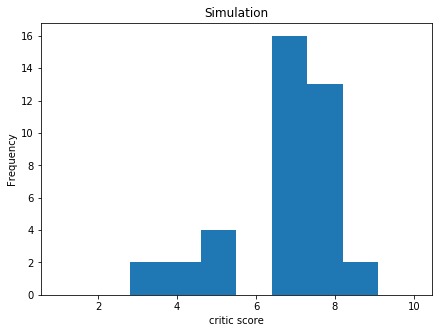

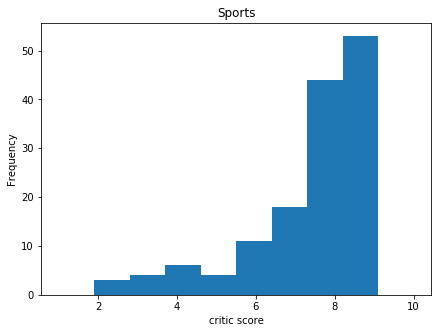

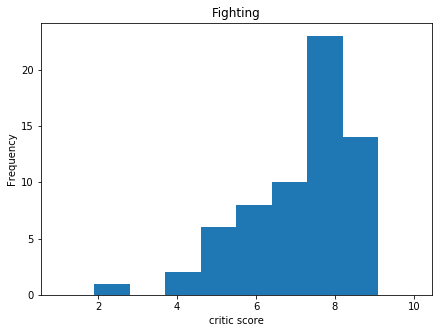

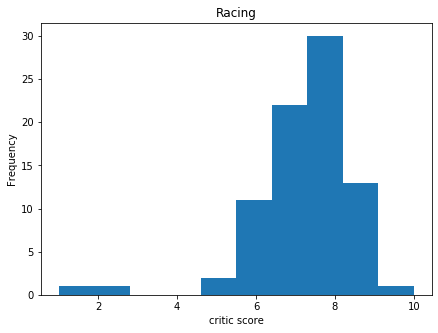

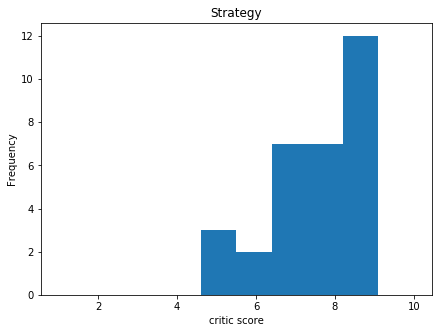

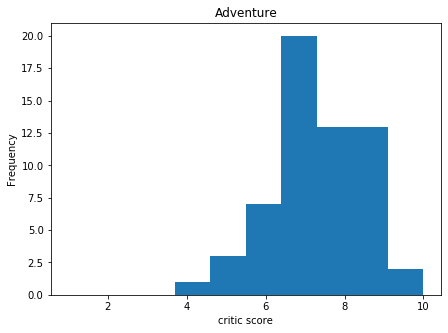

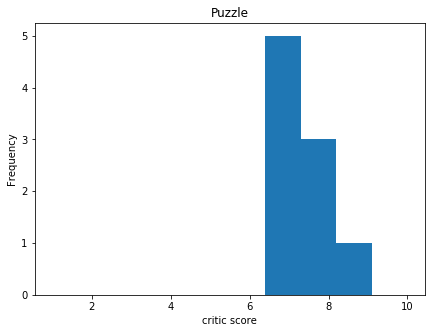

In [65]:
for g in df_upd['genre'].unique().tolist():
    plt.figure()
    df_upd[df_upd['genre'] == g]['critic_score'].plot(kind='hist', figsize=(7, 5), range=(1, 10), title=g)
    plt.xlabel('critic score')
    plt.show()


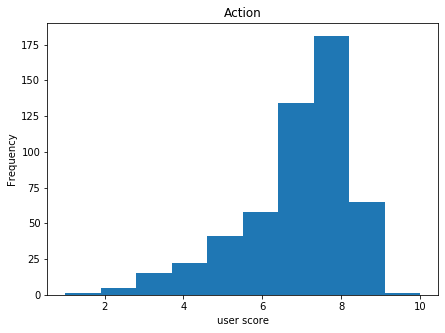

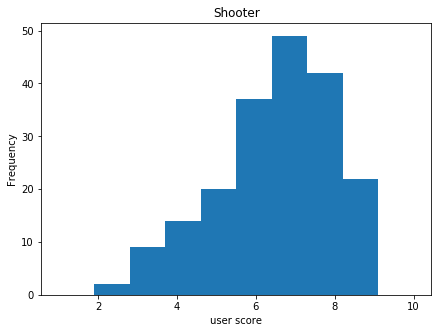

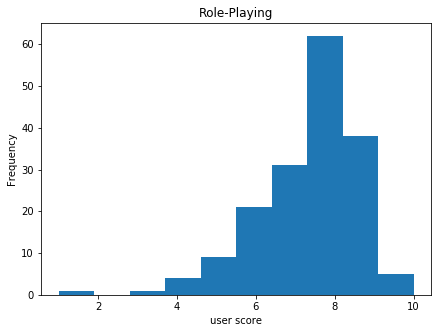

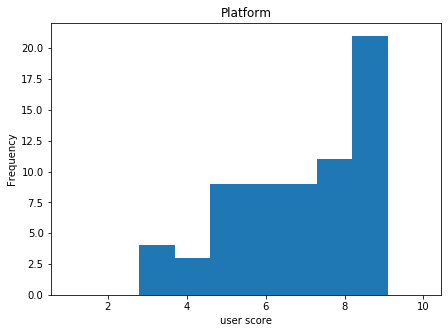

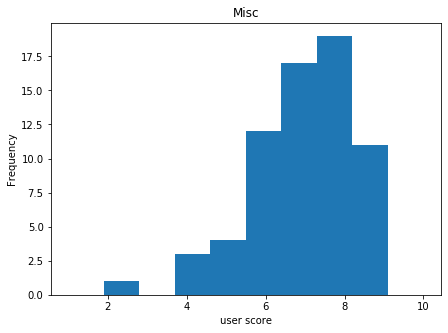

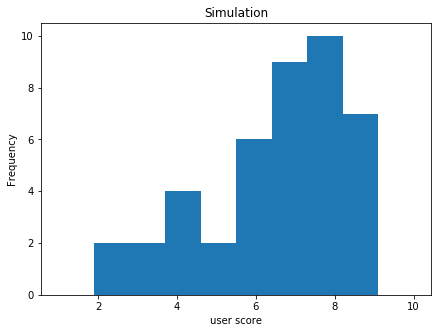

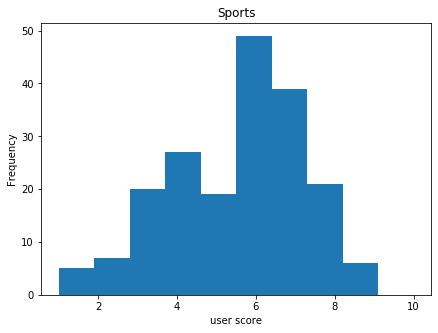

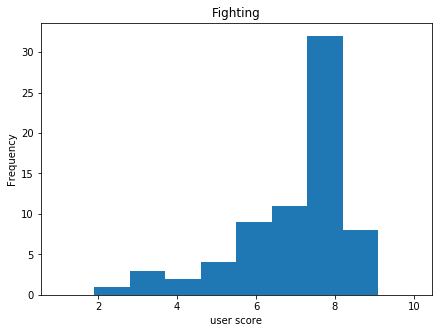

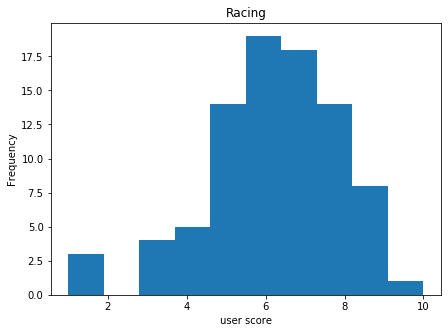

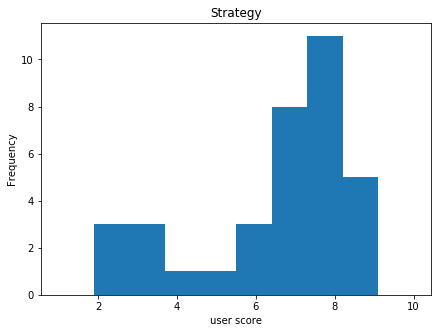

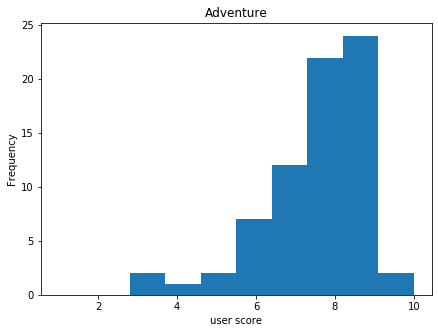

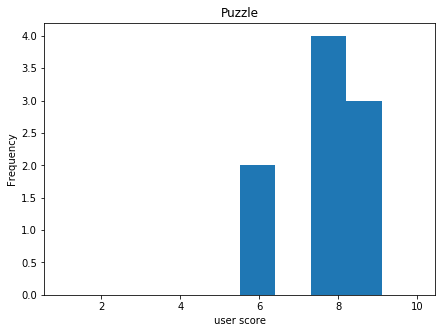

In [66]:
for g in df_upd['genre'].unique().tolist():
    plt.figure()
    df_upd[df_upd['genre'] == g]['user_score'].plot(kind='hist', figsize=(7, 5), range=(1, 10), title=g)
    plt.xlabel('user score')
    plt.show()

Мнение критиков значительно более консолидированное, беспристрастное по сравнению с мнением пользователей: все статистики имеют очень близкие, ровные показатели по жанрам, в то время как у пользователей есть более выраженные предпочтения.

### 7. Проверка гипотез

In [67]:
# Средние пользовательские рейтинги платформ Xbox One и PC одинаковые?
# H0 - Средние пользовательские рейтинги платформ Xbox One и PC равны между собой.

#сначала дропнем пропуски в признаке user_score. Для проверки гипотезы это кажется разумным.
df_upd_u = df_upd.dropna(subset=['user_score'])

sample_1 = df_upd_u[df_upd_u['platform'] == 'XOne']['user_score']
sample_2 = df_upd_u[df_upd_u['platform'] == 'PC']['user_score']
results = st.ttest_ind(sample_1, sample_2)
print('p-значение: ', results.pvalue)

p-значение:  0.5535080500643661


p-значение больше 5%, следовательно, нулевая гипотеза принимается, считаем, что средние пользовательские рейтинги платформ Xbox One и PC равны между собой

In [68]:
# Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные
# H0 - Средние пользовательские рейтинги жанров Action и Sports равны между собой.

sample_1 = df_upd_u[df_upd_u['genre'] == 'Action']['user_score']
sample_2 = df_upd_u[df_upd_u['genre'] == 'Sports']['user_score']
results = st.ttest_ind(sample_1, sample_2)
print('p-значение: ', results.pvalue)

p-значение:  3.7163089460934874e-26


p-значение практически равно нулю, следовательно, нулевая гипотеза отвергается, считаем, что средние пользовательские рейтинги жанров Action и Sports не равны между собой, различаются

In [69]:
# Дисперсии для наших выборок соответственно:

# df_upd_u[df_upd_u['platform'] == 'XOne']['user_score'].std()**2, 
print('platform = XOne', np.var(df_upd_u[df_upd_u['platform'] == 'XOne']['user_score']))
print('platform = PC', np.var(df_upd_u[df_upd_u['platform'] == 'PC']['user_score']))
print('genre = Action', np.var(df_upd_u[df_upd_u['genre'] == 'Action']['user_score']))
print('genre = Sports', np.var(df_upd_u[df_upd_u['genre'] == 'Sports']['user_score']))


platform = XOne 1.8965188383045526
platform = PC 2.7569952398906588
genre = Action 1.8854720340439224
genre = Sports 3.0073882971729127


Поскольку дисперсии в сравниваемых выборках отличаются, параметр equal_var выставим в False.

In [70]:
# Средние пользовательские рейтинги платформ Xbox One и PC одинаковые?
# H0 - Средние пользовательские рейтинги платформ Xbox One и PC равны между собой.

#сначала дропнем пропуски в признаке user_score. Для проверки гипотезы это кажется разумным.
df_upd_u = df_upd.dropna(subset=['user_score'])

sample_1 = df_upd_u[df_upd_u['platform'] == 'XOne']['user_score']
sample_2 = df_upd_u[df_upd_u['platform'] == 'PC']['user_score']
results = st.ttest_ind(sample_1, sample_2, equal_var=False)
print('p-значение: ', results.pvalue)

p-значение:  0.5489537965134912


Welch’s t-test не привел к изменениям. По прежнему p-значение больше 5%, следовательно, нулевая гипотеза принимается, считаем, что средние пользовательские рейтинги платформ Xbox One и PC равны между собой

In [71]:
# Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные
# H0 - Средние пользовательские рейтинги жанров Action и Sports равны между собой.

sample_1 = df_upd_u[df_upd_u['genre'] == 'Action']['user_score']
sample_2 = df_upd_u[df_upd_u['genre'] == 'Sports']['user_score']
results = st.ttest_ind(sample_1, sample_2, equal_var=False)
print('p-значение: ', results.pvalue)

p-значение:  4.24307776572644e-20


Welch’s t-test не привел к изменениям. По прежнему p-значение практически равно нулю, следовательно, нулевая гипотеза отвергается, считаем, что средние пользовательские рейтинги жанров Action и Sports не равны между собой, различаются.

### 8. Общий вывод

Для успешных продаж на следующий год есть смысл:
1. Рассматривать игры с годом выпуска не ранее 2012.
2. Продвигать на рынки NA и EU игры платформ PS4, XOne, X360, PS3, DS, а для рынка JP игры платформы X-Box стоит заменить на PSV и WiiU.
3. Рассматривать жанры Action, Shooter, Sports, Role-Playing, остальные не рекомендуются к продвижению.
4. Все игры с рейтингом критиков меньше 7 и пользовательским рейтингом от 2 и ниже исключить из продвижения.
5. В США обратить внимание на продвижение игр с рейтингом ESRB М. В Европе - с индексом Е, а Японии - с индексом Т. Игры с индексом М в Японии лучше не продвигать.
6. Ну, и, если не противоречит амбициям по доле рынка, отобрать игры со среднегодовой выручкой выше средней по жанру. Среднегодовая выручка - это выручка делить на количество лет с выпуска игры. Так в рассмотрение будут включены свежие игры.